# Data Preprocessing

In [236]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1d'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1d', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

dir_  = pd.Series(
    np.where(ret1 >= 0, 1, 0),
    index=ret1.index,
    name='dir'
)

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
0    668
1    655
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-07,52586.77,52818.37,43000.00,46729.20,645.126118,18.635134,193.171459,1185.709987,2640.824360,-0.227866,-0.849630,1.0,95818.37,1.228334,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.271190e+09,9818.37,1435656.54,1.570775,46730.0,0.407693,46729.0,10.752125,4.669588,0.913119,216.169378,2.239724,28.294841,33.776386,919.061795,100.000000,100.000000,0.0,-0.596593,-82.288544,-4.450960,22.825941,1588.845268,1844.472121,-255.626853,919.061795,1182.885726,-263.823932,1517.644555,1762.038593,-244.394038,59.821484,29.733322,10900.650538,-2155.64,18.682056,6849.102442,1.905808,-4.409629,-0.044096,0.955904,95.590371,47.774520,78.052107,84.235899,37.981865,78.052107,0.000000,66.666667,56.246084,-62.018135,54207.512275,50187.278,46167.043725,51260.777269,47019.503009,48206.442387,47599.349994,47855.218000,48169.377335,47496.809775,49657.985,47909.185,52818.370000,-52818.370000,47855.218000,50338.783665,47942.271542,48607.124688,0.0,0.0,0.0,0.0,0.0,-80.0,0.0,0.0,0.0,0.0,0.0,0.0,-200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48783.5850,47909.185,47515.856667,47319.1925,1.280292,0.687029,50108.163714,89.673638,47825.924857,175.556835,2010.117137,50283.720549,4.040571e+06,2620.988328,5.608888,9818.37,1103.680104,133.580534,1048.136021,-0.111389,0
2021-09-08,46729.20,47299.87,44436.94,46014.25,407.756328,18.475897,197.380038,1927.090095,1588.805912,-0.298708,-0.886042,1.0,91736.81,1.064427,52586.77,63.0,44412.00,38.0,44412.00,52586.77,38.0,63.0,2.101861e+09,2862.93,1435385.46,1.570775,46015.0,-0.791463,46014.0,10.736706,4.662892,0.611217,214.509324,-0.772262,27.904205,32.846811,736.058462,92.857143,92.857143,0.0,-0.249727,-147.476793,-8.106458,22.825941,1218.622897,1719.302276,-500.679379,736.058462,1065.713903,-329.655442,1168.501409,1643.331156,-474.829747,51.103176,27.426780,10122.032642,-2742.33,17.232809,6359.880839,1.528511,-5.624533,-0.056245,0.943755,94.375467,45.946771,55.639083,74.829356,30.700106,55.639083,0.000000,33.333333,53.55

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

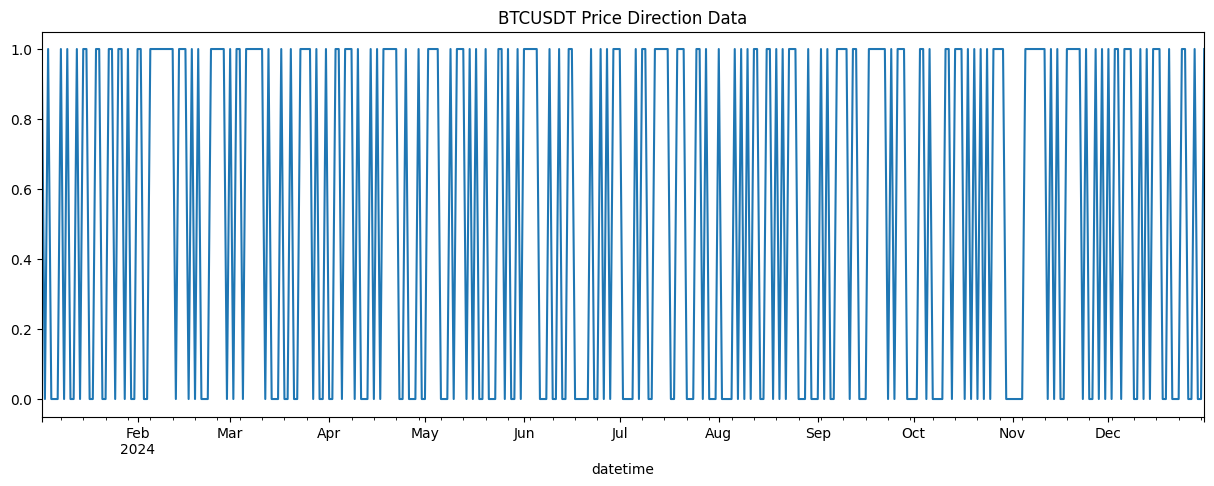

In [237]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2024-01-01') & (df_all.index < '2025-01-01')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Feature Engineering and Selection

- Used Robust 

In [238]:
import pandas as pd, numpy as np
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
N_SPLITS    = 3
KEEP_PCT    = 0.30

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# 2) build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# 3) Apply Robust standardization to features(X) ────────────────────────
scaler = RobustScaler()
X_lag_scaled = pd.DataFrame(scaler.fit_transform(X_lag),index=X_lag.index,columns=X_lag.columns)

# 4) avg MI over folds ──────────────────────────────────────────────────
mi = pd.Series(0.0, index=X_lag_scaled.columns)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for tr, _ in tscv.split(X_lag_scaled):
    mi  += mutual_info_classif(X_lag_scaled.iloc[tr], y.iloc[tr], discrete_features=False)
mi /= N_SPLITS

# 5) keep top KEEP_PCT of lags ──────────────────────────────────────────
k        = int(len(mi) * KEEP_PCT)
top_feats= mi.nlargest(k).index
X_red    = X_lag_scaled[top_feats]
X_red

,HT_SINE_leadsine_lag2,MACDFIX_macdhist_lag3,CMO_real_lag6,RSI_real_lag6,CDLSTALLEDPATTERN_integer_lag4,ADX_real_lag6,MACDEXT_macdsignal_lag1,MACDEXT_macdhist_lag1,TYPPRICE_real_lag9,AROON_aroonup_lag9,ADX_real_lag1,STOCHRSI_fastk_lag4,DIV_real_lag1,OBV_real_lag2,HT_PHASOR_quadrature_lag14,CDLBELTHOLD_integer_lag6,ATR_real_lag10,COS_real_lag9,DIV_real_lag10,ROC_real_lag10,ROCP_real_lag10,ROCR_real_lag10,ROCR100_real_lag10,ADXR_real_lag5,DEMA_real_lag6,FLOOR_real_lag2,CEIL_real_lag2,SQRT_real_lag2,LN_real_lag2,LOG10_real_lag2,HT_SINE_sine_lag9,open_lag1,close_lag2,DIV_real_lag5,VAR_real_lag8,OBV_real_lag3,ATAN_real_lag2,STDDEV_real_lag8,DX_real_lag2,MACDFIX_macd_lag4,MIDPRICE_real_lag8,SUB_real_lag5,ROC_real_lag4,ROCP_real_lag4,ROCR_real_lag4,ROCR100_real_lag4,TRANGE_real_lag5,BBANDS_middleband_lag1,CDLGRAVESTONEDOJI_integer_lag3,CDLHIKKAKEMOD_integer_lag10,TSF_real_lag10,APO_real_lag4,MACDEXT_macd_lag4,HT_TRENDMODE_integer_lag6,BBANDS_upperband_lag13,WCLPRICE_real_lag6,BBANDS_upperband_lag1,PPO_real_lag11,APO_real_lag11,MACDEXT_macd_lag11,MULT_real_lag5,STOCH_slowd_lag11,ADXR_real_lag4,MACD_macd_lag4,DIV_real_lag8,PPO_real_lag10,CMO_real_lag9,RSI_real_lag9,STOCHRSI_fastd_lag5,ret1_lag3,MACD_macdhist_lag3,MACDEXT_macdsignal_lag13,CDLADVANCEBLOCK_integer_lag2,ADOSC_real_lag6,MACDFIX_macdsignal_lag1,EMA_real_lag14,WCLPRICE_real_lag9,CDLHIKKAKE_integer_lag1,HT_PHASOR_inphase_lag10,WILLR_real_lag4,CDLHANGINGMAN_integer_lag11,TAN_real_lag1,STOCH_slowd_lag13,TSF_real_lag7,AROONOSC_real_lag5,MINUS_DM_real_lag13,AVGPRICE_real_lag6,HT_SINE_leadsine_lag9,MFI_real_lag5,SUM_real_lag1,MA_real_lag1,SMA_real_lag1,ADD_real_lag5,MEDPRICE_real_lag5,CDLMATCHINGLOW_integer_lag6,SIN_real_lag5,WILLR_real_lag1,HT_PHASOR_inphase_lag12,MACD_macdhist_lag2,low_lag10,CDLDOJI_integer_lag14,MIDPRICE_real_lag6,CDLSTALLEDPATTERN_integer_lag7,CDLGRAVESTONEDOJI_integer_lag4,MACD_macdsignal_lag1,HT_SINE_leadsine_lag7,LINEARREG_INTERCEPT_real_lag4,ADD_real_lag2,MEDPRICE_real_lag2,OBV_real_lag9,ATAN_real_lag1,CMO_real_lag8,RSI_real_lag8,HT_DCPHASE_real_lag2,CDLGRAVESTONEDOJI_integer_lag11,volume_lag10,MACD_macdhist_lag12,CEIL_real_lag1,CDLLONGLINE_integer_lag10,close_lag1,CDLADVANCEBLOCK_integer_lag9,FLOOR_real_lag1,low_lag11,SQRT_real_lag1,SAR_real_lag8,LN_real_lag1,LOG10_real_lag1,PLUS_DI_real_lag6,AROON_aroondown_lag13,MAMA_mama_lag5,HT_DCPHASE_real_lag9,LINEARREG_INTERCEPT_real_lag3,CDLTAKURI_integer_lag3,TSF_real_lag11,MACDFIX_macdsignal_lag3,STOCH_slowk_lag5,STOCHF_fastd_lag5,ROC_real_lag13,ROCP_real_lag13,ROCR_real_lag13,ROCR100_real_lag13,HT_DCPERIOD_real_lag5,MACDFIX_macdhist_lag2,PLUS_DM_real_lag11,AROON_aroonup_lag8,MULT_real_lag2,CDLHARAMI_integer_lag10,CDLTAKURI_integer_lag1,CEIL_real_lag9,CDLBELTHOLD_integer_lag5,MINMAX_max_lag6,ATAN_real_lag9,FLOOR_real_lag9,WILLR_real_lag5,WILLR_real_lag11,CCI_real_lag10,open_lag8,close_lag9,MINMAXINDEX_maxidx_lag7,CDLADVANCEBLOCK_integer_lag8,STOCHF_fastk_lag13,CDLTAKURI_integer_lag2,SQRT_real_lag9,AD_real_lag1,MAXINDEX_integer_lag14,TAN_real_lag2,LN_real_lag9,LOG10_real_lag9,DX_real_lag5,CDLCLOSINGMARUBOZU_integer_lag3,CDLSHORTLINE_integer_lag13,BOP_real_lag2,ret1_lag8,STDDEV_real_lag14,BETA_real_lag9,MACD_macd_lag12,CDLSHORTLINE_integer_lag4,CDLHAMMER_integer_lag5,TAN_real_lag7,ULTOSC_real_lag5,AROON_aroondown_lag14,ret1_lag10,ADD_real_lag9,MEDPRICE_real_lag9,MAXINDEX_integer_lag6,ret1_lag5,HT_TRENDMODE_integer_lag3,SIN_real_lag4,CMO_real_lag5,RSI_real_lag5,CDLLONGLEGGEDDOJI_integer_lag5,CMO_real_lag2,RSI_real_lag2,VAR_real_lag14,CDLADVANCEBLOCK_integer_lag5,AROONOSC_real_lag9,T3_real_lag8,CDLENGULFING_integer_lag8,DIV_real_lag11,STOCH_slowd_lag8,CDLRICKSHAWMAN_integer_lag5,CDLHANGINGMAN_integer_lag3,AROON_aroonup_lag10,MACD_macdsignal_lag13,CDLCLOSINGMARUBOZU_integer_lag7,CDLLONGLINE_integer_lag14,AROON_aroondown_lag11,CDLHANGINGMAN_integer_lag1,MOM_real_lag13,CDLLONGLINE_integer_lag12,CDLHARAMICROSS_integer_lag13,LINEARREG_ANGLE_real_lag5,STOCHRSI_fastd_lag8,HT_SINE_leadsine_lag12,MACD_macdhist_lag10,LINEARREG

In [239]:
# import pandas as pd, numpy as np
# from sklearn.compose         import ColumnTransformer
# from sklearn.preprocessing   import RobustScaler
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.feature_selection import mutual_info_classif

# # ── CONFIG ─────────────────────────────────────────────────────────────
# TARGET      = 'dir'
# MAX_LAG     = 14
# N_SPLITS    = 5
# KEEP_PCT    = 0.30
# HEAVY_PREF  = ('volume','ATR','OBV')

# # 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
# y  = df_all[TARGET]
# X0 = df_all.drop(columns=[TARGET])

# # build lags 1…MAX_LAG
# frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
# X_lag = pd.concat(frames, axis=1).dropna()
# y     = y.loc[X_lag.index]

# # X_red = X_lag.copy()

# # robust-scale heavy tails
# heavy = [c for c in X_lag.columns if c.startswith(HEAVY_PREF)]
# ct = ColumnTransformer([
#     ('robust', RobustScaler(), heavy),
#     ('keep',   'passthrough', [c for c in X_lag.columns if c not in heavy])
# ])

# # avg MI over folds
# mi = pd.Series(0.0, index=X_lag.columns)
# tscv = TimeSeriesSplit(n_splits=N_SPLITS)
# for tr, _ in tscv.split(X_lag):
#     Xtr = ct.fit_transform(X_lag.iloc[tr])
#     ytr = y.iloc[tr]
#     mi  += mutual_info_classif(Xtr, ytr, discrete_features=False)
# mi /= N_SPLITS

# # keep top KEEP_PCT of lags
# k        = int(len(mi) * KEEP_PCT)
# top_feats= mi.nlargest(k).index
# X_red    = X_lag[top_feats]

In [240]:
# # X is your DataFrame of selected features
# corr = X_red.corr(method='spearman').abs()

# # Build an “upper triangle” mask
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# # Find columns to drop: any that have corr > thresh with an earlier col
# to_drop = [col for col in upper.columns if any(upper[col] > 0.8)]

# X_reduced = X_red.drop(columns=to_drop)
# X_reduced

X_reduced = X_red.copy()

## Feature Selection Method 1: Boruta

In [292]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1) Set up a RandomForest with enough trees ----------------------------
rf = RandomForestClassifier(
    n_estimators=1000,        # BorutaPy will actually override this with 'auto'
    max_depth=3,
    n_jobs=-1,
    random_state=42
)

# --- 2) Wrap in BorutaPy ---------------------------------------------------
boruta = BorutaPy(
    estimator=rf,
    n_estimators=1000,        # let Boruta pick a sufficient forest size
    verbose=False,              # shows you progress of the shadow‐feature tests
    random_state=42,
)

# --- 3) Fit on your training data ------------------------------------------
# Pass the raw values; BorutaPy does its own internal shadow‐feature testing
boruta.fit(X_reduced.values, y.values)

# --- 4) Extract and rank all features by Boruta rank ------------------------
# boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
ranks = pd.Series(boruta.ranking_, index=X_reduced.columns)

# Sort ascending (1 = best), then take the top 10 names
boruta_selected_mc = ranks.sort_values().head(10).index.tolist()
X_boruta = X_reduced[boruta_selected_mc].copy() 

print("Top 10 features by Boruta rank:")
for i, feat in enumerate(boruta_selected_mc, 1):
    print(f"{i:2d}. {feat} (rank={ranks[feat]})")


Top 10 features by Boruta rank:
 1. STOCHF_fastk_lag1 (rank=1)
 2. ret1_lag9 (rank=2)
 3. ret1_lag1 (rank=3)
 4. ret1_lag5 (rank=4)
 5. DIV_real_lag5 (rank=5)
 6. STOCHF_fastk_lag9 (rank=6)
 7. OBV_real_lag1 (rank=7)
 8. MACDFIX_macdhist_lag1 (rank=8)
 9. SUB_real_lag5 (rank=9)
10. ROCR100_real_lag1 (rank=10)


In [309]:
corr = X_boruta.corr()
corr

,STOCHF_fastk_lag1,ret1_lag9,ret1_lag1,ret1_lag5,DIV_real_lag5,STOCHF_fastk_lag9,OBV_real_lag1,MACDFIX_macdhist_lag1,SUB_real_lag5,ROCR100_real_lag1
STOCHF_fastk_lag1,1.000000,-0.040913,0.607950,0.114126,0.023128,-0.000845,0.086002,0.401115,0.050041,0.495977
ret1_lag9,-0.040913,1.000000,-0.025636,0.015123,-0.026185,0.609695,0.015458,0.153948,0.000505,0.297146
ret1_lag1,0.607950,-0.025636,1.000000,0.014331,-0.016315,0.003440,0.022174,0.165057,-0.017674,0.323991
ret1_lag5,0.114126,0.015123,0.014331,1.000000,-0.047956,-0.001083,0.021679,0.308399,-0.006240,0.325973
DIV_real_lag5,0.023128,-0.026185,-0.016315,-0.047956,1.000000,-0.073707,0.179503,-0.074755,0.715638,-0.109943
STOCHF_fastk_lag9,-0.000845,0.609695,0.003440,-0.001083,-0.073707,1.000000,0.082621,0.178290,0.032876,0.312345
OBV_real_lag1,0.086002,0.015458,0.022174,0.021679,0.179503,0.082621,1.000000,-0.009713,0.541988,0.059644
MACDFIX_macdhist_lag1,0.401115,0.153948,0.165057,0.308399,-0.074755,0.178290,-0.009713,1.000000,-0.114222,0.760338
SUB_real_lag5,0.050041,0.000505,-0.017674,-0.006240,0.715638,0.032876,0.541988,-0.114222,1.000000,-0.028999
ROCR100_real_lag1,0.495977,0.297146,0.323991,0.325973,-0.109943,0.312345,0.059644,0.760338,-0.028999,1.000000


## Feature Selection Method 2: Genetic Algorithm

In [242]:
# ## In[3]: Genetic Algorithm (wrapper) for multiclass
# from sklearn.ensemble import RandomForestClassifier
# from genetic_selection import GeneticSelectionCV

# estimator_mc = RandomForestClassifier(n_jobs=-1, random_state=42)
# selector_mc = GeneticSelectionCV(
#     estimator=estimator_mc,
#     cv=5,
#     scoring='accuracy',
#     n_population=50,
#     crossover_proba=0.5,
#     mutation_proba=0.2,
#     n_generations=40,
#     n_jobs=-1,
#     max_features=50,
#     verbose=10
# )
# selector_mc.fit(X_red.values, y.values)
# ga_selected_mc = list(X_red.columns[selector_mc.support_])
# print("GA selected (multiclass):", ga_selected_mc)
# X_ga = X_red[ga_selected_mc].copy()

## Feature Selection Method 3: LightGMB

In [243]:
# ## In[4]: LightGBM embedded for multiclass
# import lightgbm as lgb

# lgbm_mc = lgb.LGBMClassifier(
#     objective='multiclass',
#     num_class=3,
#     random_state=42
# )
# lgbm_mc.fit(X_red, y)
# importances_mc = pd.Series(
#     lgbm_mc.feature_importances_, index=X_red.columns
# )
# lgbm_selected_mc = list(importances_mc.nlargest(10).index)
# print("LightGBM top 15 (multiclass):", lgbm_selected_mc)

# # 2) Use only selected features for tuning
# X_lgbm = X_red[lgbm_selected_mc].copy()

# Machine Learning 

In [302]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pandas as pd

# 1) Prepare X and y
X = X_boruta.copy()   
y = y.copy()

split_idx = int(0.5*len(X))
X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_val = X.iloc[split_idx+1:]
y_val = y.iloc[split_idx+1:]

clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    # use_label_encoder=False,
    random_state=42,
    n_jobs=-1,

    # Complexity control
    n_estimators=10000,          # start big, prune with ES
    early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
    max_depth=3,                # shallow trees generalize better
    learning_rate=0.001,         # smaller step size → smoother fit
    subsample=0.8,              # row sampling
    colsample_bytree=0.8,       # feature sampling

    # Split regularization
    gamma=1.0,                  # min loss reduction to make a split
    min_child_weight=5,         # min sum hessian in a leaf

    # Weight regularization
    reg_alpha=1.,              # L1
    reg_lambda=1.5,             # L2
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100,
)

[0]	validation_0-logloss:0.69218	validation_1-logloss:0.69510
[100]	validation_0-logloss:0.68725	validation_1-logloss:0.69442
[200]	validation_0-logloss:0.68269	validation_1-logloss:0.69377
[300]	validation_0-logloss:0.67832	validation_1-logloss:0.69299
[400]	validation_0-logloss:0.67405	validation_1-logloss:0.69246
[500]	validation_0-logloss:0.67015	validation_1-logloss:0.69194
[600]	validation_0-logloss:0.66634	validation_1-logloss:0.69151
[700]	validation_0-logloss:0.66280	validation_1-logloss:0.69116
[800]	validation_0-logloss:0.65929	validation_1-logloss:0.69083
[900]	validation_0-logloss:0.65590	validation_1-logloss:0.69042
[1000]	validation_0-logloss:0.65270	validation_1-logloss:0.69007
[1100]	validation_0-logloss:0.64950	validation_1-logloss:0.68984
[1200]	validation_0-logloss:0.64648	validation_1-logloss:0.68953
[1300]	validation_0-logloss:0.64346	validation_1-logloss:0.68928
[1400]	validation_0-logloss:0.64058	validation_1-logloss:0.68906
[1500]	validation_0-logloss:0.63777	v

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              random_state=42, ...)

<Axes: >

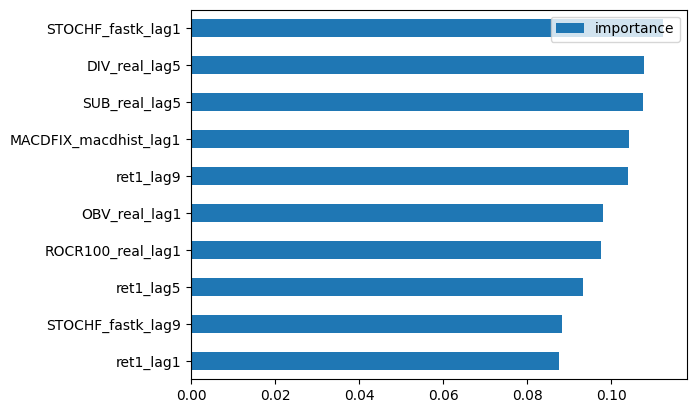

In [303]:
fi = pd.DataFrame(data = clf.feature_importances_,
                  index = clf.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind='barh')

In [304]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)

# 2) Compute accuracy
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Validation accuracy: 0.5306

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       319
           1       0.58      0.32      0.41       335

    accuracy                           0.53       654
   macro avg       0.54      0.54      0.51       654
weighted avg       0.54      0.53      0.51       654


Confusion Matrix:
[[240  79]
 [228 107]]


In [305]:
# 1) Predict labels on the validation set
y_proba = clf.predict_proba(X_val)
y_proba = y_proba.max(axis=1)

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)
y_pred_confident = y_pred[y_proba>0.56]
y_test_confident = y_val[y_proba>0.56]

# 2) Compute accuracy
val_accuracy = accuracy_score(y_test_confident, y_pred_confident)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_test_confident, y_pred_confident))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_confident, y_pred_confident))

Validation accuracy: 0.5802

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.89      0.69       156
           1       0.65      0.23      0.34       137

    accuracy                           0.58       293
   macro avg       0.61      0.56      0.51       293
weighted avg       0.60      0.58      0.53       293


Confusion Matrix:
[[139  17]
 [106  31]]


In [306]:
print(f"percentage of trade occured per 1d data: {len(y_test_confident)/len(y_val)*100:.3}%")

percentage of trade occured per 1d data: 44.8%
